# ETL con la API OpenWeatherMap

El siguiente es un ETL realizado con la API de OpenWeatherMap en su sitio web https://home.openweathermap.org/api_keys

Se empieza importando las librerias, principalmente requests y jason para el tratamiento de los objetos json que se tenga en respuesta.

In [107]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

Se inicializan estas variables, analizaré London

In [108]:
url = 'https://api.openweathermap.org/data/2.5/forecast'
api_key = '9a37067b5a201aa7eec4eaec76921d29'
city = 'London'
units = 'metric'

Se pasan las variables anteriores a los parametros y se empiezan a recolectar los datos.

In [109]:
params = {'q': city, 'appid': api_key, 'units': units}
response = requests.get(url, params=params)
data = response.json()

Este paso lo utilizo para poder visualizar el objeto json, y las estructuras de tipo diccionario que tiene.

In [110]:
output = json.dumps(data)
print(output)

{"cod": "200", "message": 0, "cnt": 40, "list": [{"dt": 1677726000, "main": {"temp": 2.79, "feels_like": 0.24, "temp_min": 2.22, "temp_max": 2.79, "pressure": 1024, "sea_level": 1024, "grnd_level": 1021, "humidity": 83, "temp_kf": 0.57}, "weather": [{"id": 803, "main": "Clouds", "description": "broken clouds", "icon": "04n"}], "clouds": {"all": 52}, "wind": {"speed": 2.55, "deg": 30, "gust": 8.2}, "visibility": 10000, "pop": 0, "sys": {"pod": "n"}, "dt_txt": "2023-03-02 03:00:00"}, {"dt": 1677736800, "main": {"temp": 2.17, "feels_like": -0.65, "temp_min": 1.72, "temp_max": 2.17, "pressure": 1025, "sea_level": 1025, "grnd_level": 1022, "humidity": 85, "temp_kf": 0.45}, "weather": [{"id": 802, "main": "Clouds", "description": "scattered clouds", "icon": "03n"}], "clouds": {"all": 27}, "wind": {"speed": 2.72, "deg": 29, "gust": 8.72}, "visibility": 10000, "pop": 0, "sys": {"pod": "n"}, "dt_txt": "2023-03-02 06:00:00"}, {"dt": 1677747600, "main": {"temp": 4.02, "feels_like": 0.8, "temp_min

Se transforma el formato json a dataframe de pandas, la columna dt a tipo datetime.

In [111]:
df = pd.json_normalize(data["list"])
df['dt'] = pd.to_datetime(df['dt'], unit='s')
df = df.set_index('dt')

In [112]:
df.head(2)

,weather,visibility,pop,dt_txt,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.sea_level,main.grnd_level,main.humidity,main.temp_kf,clouds.all,wind.speed,wind.deg,wind.gust,sys.pod,rain.3h,snow.3h
dt,,,,,,,,,,,,,,,,,,,,
2023-03-02 03:00:00,"[{'id': 803, 'main': 'Clouds', 'description': ...",10000,0.0,2023-03-02 03:00:00,2.79,0.24,2.22,2.79,1024,1024,1021,83,0.57,52,2.55,30,8.20,n,NaN,NaN
2023-03-02 06:00:00,"[{'id': 802, 'main': 'Clouds', 'description': ...",10000,0.0,2023-03-02 06:00:00,2.17,-0.65,1.72,2.17,1025,1025,1022,85,0.45,27,2.72,29,8.72,n,NaN,NaN


Se puede ver que la primera columna tiene valores de lista y diccionarios dentro, por ello se dividen en diferentes columnas para continuar con un mejor EDA.

In [113]:
datos_divididos = df.weather.apply(lambda x: pd.Series(x[0])).add_prefix('weather_')

df = pd.concat([df, datos_divididos], axis=1).drop(['weather'], axis=1)

df.head(2)

,visibility,pop,dt_txt,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.sea_level,main.grnd_level,...,wind.speed,wind.deg,wind.gust,sys.pod,rain.3h,snow.3h,weather_id,weather_main,weather_description,weather_icon
dt,,,,,,,,,,,,,,,,,,,,,
2023-03-02 03:00:00,10000,0.0,2023-03-02 03:00:00,2.79,0.24,2.22,2.79,1024,1024,1021,...,2.55,30,8.20,n,NaN,NaN,803,Clouds,broken clouds,04n
2023-03-02 06:00:00,10000,0.0,2023-03-02 06:00:00,2.17,-0.65,1.72,2.17,1025,1025,1022,...,2.72,29,8.72,n,NaN,NaN,802,Clouds,scattered clouds,03n


Al final del dataframe se pueden ver las nuevas columnas extraidas de la columna de listas.

In [114]:
print(df.columns.values)

['visibility' 'pop' 'dt_txt' 'main.temp' 'main.feels_like' 'main.temp_min'
 'main.temp_max' 'main.pressure' 'main.sea_level' 'main.grnd_level'
 'main.humidity' 'main.temp_kf' 'clouds.all' 'wind.speed' 'wind.deg'
 'wind.gust' 'sys.pod' 'rain.3h' 'snow.3h' 'weather_id' 'weather_main'
 'weather_description' 'weather_icon']


Se crean dos columnas a partir del indice dt, la cual es el datetime de mas arriba.

In [115]:
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

Se hace un muestreo con frecuencia diaria.

In [116]:
df_daily = df.resample('D').mean()

Se hace un mapa de calor en base a la temperatura principal, dia de la semana y hora.

Text(0.5, 1.0, 'Temperatura media por día de la semana y hora del día')

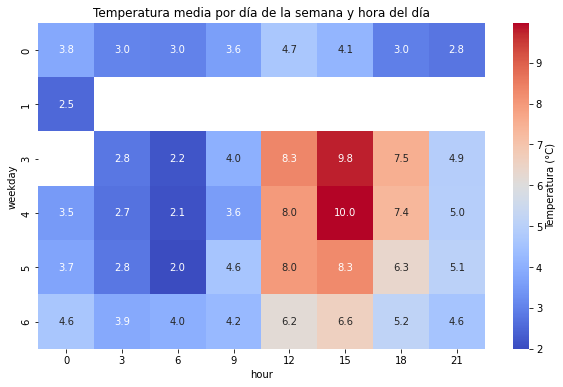

In [117]:
df_heatmap = df.pivot_table(values='main.temp', index='weekday', columns='hour')
plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap, cmap='coolwarm', annot=True, fmt='.1f', cbar_kws={'label': 'Temperatura (°C)'})
plt.title('Temperatura media por día de la semana y hora del día')

Se puede visualizar a continuación la temperatura media diaria, sería bueno llevar un abrigo los siguientes dias.

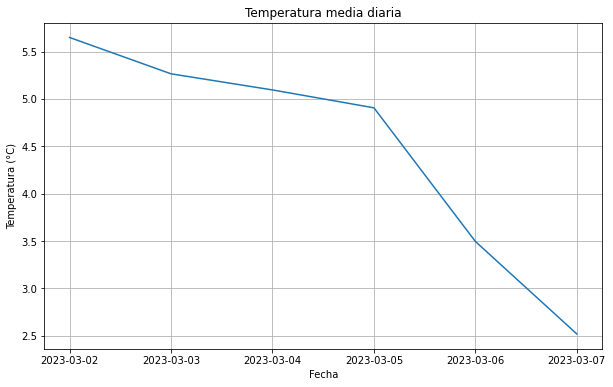

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index, df_daily['main.temp'])
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura media diaria')
plt.grid(True)

Aqui se pueden ver un grafico de frecuencias respecto a los estados del cielo, es principalmente nublado o despejado con poca probabilidad de precipitaciones.

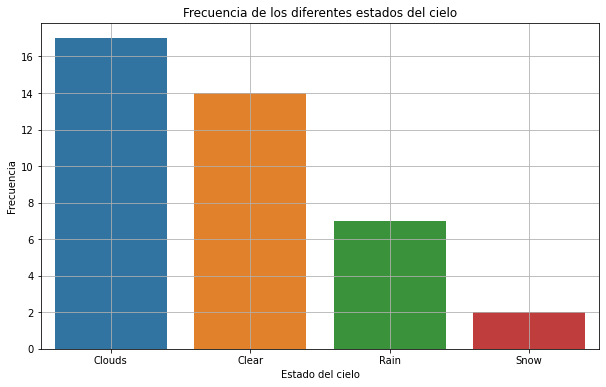

In [119]:
df_barplot = df['weather_main'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=df_barplot.index, y=df_barplot.values)
plt.xlabel('Estado del cielo')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de los diferentes estados del cielo')
plt.grid(True)
plt.show()